In [355]:
from datetime import datetime
import glob
import numpy as np
import pathlib
import os
import pickle

from typing import Dict, List

from music21 import converter, instrument, stream, note, chord

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Flatten
from keras import utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention

# **Training**

### **PARAMETERS**

In [332]:
data_path = pathlib.Path('../raw_data/midi_chopin_format_0_dataset/')
filenames = glob.glob(str(data_path/"*.mid"))
print('Number of files:', len(filenames))

Number of files: 130


In [356]:
##### PARAMETERS #####
SEQ_LENGTH = 15                 #default 100, sequence length
NUM_FILES = 10                   #len(filenames) for the whole dataset (number of files to use)
PERIOD = 5                      #default 10, saving weights every xx epoch
BATCH_SIZE = 64                 #default 64
EPOCHS = 10                     #default 200

NUM_NOTES_TO_GENERATE = 500     #default 500

### **FUNCTIONS**

In [357]:
def get_notes():
    """ Get all the notes and chords from the midi files - Call BEFORE train """
    notes = []
    
    print("Parsing files...")
    
    for file in glob.glob("../raw_data/midi_chopin_format_0_dataset/*.mid")[:NUM_FILES]:
        stream_file = converter.parse(file)

        #print("Parsing %s" % file)
                
        components_to_parse = []
        for element in stream_file.recurse():
            components_to_parse.append(element)
        
        #components_to_parse = stream_file.flat.notes #return to this to preview model output 10 epochs 1st training
    
        for element in components_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch) + " " +  str(float(element.quarterLength)))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(float(element.quarterLength)))
            elif isinstance(element, note.Rest):
                notes.append(str(element.name)  + " " + str(float(element.quarterLength)))

    with open('../raw_data/notes/notes.pickle', 'wb') as f:
        pickle.dump(notes, f)
    
    return notes

In [358]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = SEQ_LENGTH


    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = utils.to_categorical(network_output)

    return (network_input, network_output)


In [359]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(LSTM(512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.3))
    
    model.add(LSTM(512,return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

In [360]:
def train(model, network_input, network_output):
    """ train the neural network """
    now = datetime.now()
    filepath = os.path.abspath(f"model_checkpoints_weights/{now.strftime('%d-%m/%H-%M-%S')}_weights-1LSTMAtt1LSTMLayer-num_files:{NUM_FILES}-seq_length:{SEQ_LENGTH}-batch_size:{BATCH_SIZE}"+"-{epoch:03d}-{loss:.4f}.hdf5")
    checkpoint = ModelCheckpoint(
        filepath,
        period=PERIOD, #Save weights every xx epochs
        monitor='loss',
        verbose=1,
        save_best_only=False,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)


In [361]:
def train_network(notes, n_vocab):
    """ Train a Neural Network to generate music """
    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    train(model, network_input, network_output)

### **TRAIN MODEL**

In [362]:
#load files in
notes = get_notes()

# get amount of pitch names
n_vocab = len(set(notes))
print(f"n_vocab: {n_vocab}")

Parsing files...
n_vocab: 2018


In [363]:
#check notes format
notes[:5]

['1.5 0.5', 'G#3 0.5', '1.5.8 2.0', 'B-4 1.0', 'rest 0.75']

In [364]:
#check network_input shape
network_input, network_output = prepare_sequences(notes, n_vocab)
network_input.shape

(15813, 15, 1)

In [366]:
#train model
train_network(notes, n_vocab) 

Epoch 1/10


2022-12-09 22:12:46.330209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:12:46.752785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:12:46.770533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:12:46.932288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:12:47.104756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:12:47.383842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:12:47.415551: I tensorflow/core/grappler/optimizers/cust

248/248 [==============================] - 18s 56ms/step - loss: 6.1884
Epoch 2/10
248/248 [==============================] - 13s 51ms/step - loss: 5.8143
Epoch 3/10
248/248 [==============================] - 13s 51ms/step - loss: 5.7600
Epoch 4/10
248/248 [==============================] - 13s 51ms/step - loss: 5.7065
Epoch 5/10
248/248 [==============================] - ETA: 0s - loss: 5.6600
Epoch 5: saving model to /Users/aurelie_emma/code/aeraymd/chopin_28_prelude/notebooks-aurelie/model_checkpoints_weights/09-12/22-12-43_weights-1LSTMAtt1LSTMLayer-num_files:10-seq_length:15-batch_size:64-005-5.6600.hdf5
248/248 [==============================] - 13s 51ms/step - loss: 5.6600
Epoch 6/10
248/248 [==============================] - 13s 52ms/step - loss: 5.6066
Epoch 7/10
248/248 [==============================] - 13s 52ms/step - loss: 5.5684
Epoch 8/10
248/248 [==============================] - 13s 51ms/step - loss: 5.5185
Epoch 9/10
248/248 [==============================] - 12s 50ms

# **Generating music**

### **MANUAL INPUT BEFORE GENERATOR STEP**

In [367]:
#Path to the weights to load
WEIGHTS_PATH = 'model_checkpoints_weights/'+'09-12/22-12-43_weights-1LSTMAtt1LSTMLayer-num_files:10-seq_length:15-batch_size:64-010-5.4551.hdf5'

#Filename for generated midi file
OUTPUT_FILENAME = 'midi_output_test_2'

### **FUNCTIONS**

In [368]:
def create_network_add_weights(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(LSTM(512,
        input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features
        return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.3))
    
    model.add(LSTM(512,return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

In [369]:
def prepare_sequences_output(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = SEQ_LENGTH
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)


In [370]:
def generate_notes(model, network_input, pitchnames, n_vocab, NUM_NOTES_TO_GENERATE):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate notes
    for note_index in range(NUM_NOTES_TO_GENERATE):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [371]:
#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [372]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        pattern = pattern.split()
        temp = pattern[0]
        duration = pattern[1]
        pattern = temp
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            #new_rest = note.Rest(pattern)
            new_rest = note.Rest()
            new_rest.offset = offset
            new_rest.storedInstrument = instrument.Piano() #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)
    now = datetime.now()
    fp = '../raw_data/model_outputs/'+f"{now.strftime('%d-%m-%Y_%H-%M-%S')}_"+OUTPUT_FILENAME+'.mid'
    midifile = midi_stream.write('midi', fp=fp)
    #midi_stream.show('midi')
    return midifile


In [373]:
def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    notes = get_notes()
    #with open('../raw_data/notes/notes.pickle', 'rb') as f:
        #notes = pickle.load(f)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences_output(notes, pitchnames, n_vocab)
    model = create_network_add_weights(normalized_input, n_vocab)
    model.build(input_shape=(None, normalized_input.shape[1], normalized_input.shape[2])) #e.g.(None,100,1)
    model.load_weights(WEIGHTS_PATH) # Load the weights to each node
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab, NUM_NOTES_TO_GENERATE)
    midifile = create_midi(prediction_output)
    return midifile


In [374]:
# TEST

# Get all pitch names
#pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))
    
#print(pitchnames)
print(n_vocab)
#print(notes)
print(len(notes))


2018
15828


### **GENERATOR**

In [375]:
#RUN THE GENERATOR
midifile = generate()

Parsing files...


2022-12-09 22:15:33.012332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:15:33.135661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:15:33.148890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:15:33.405545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [376]:
Stream = converter.parse(midifile)

In [377]:
# Listen to the model output
Stream.show('midi')

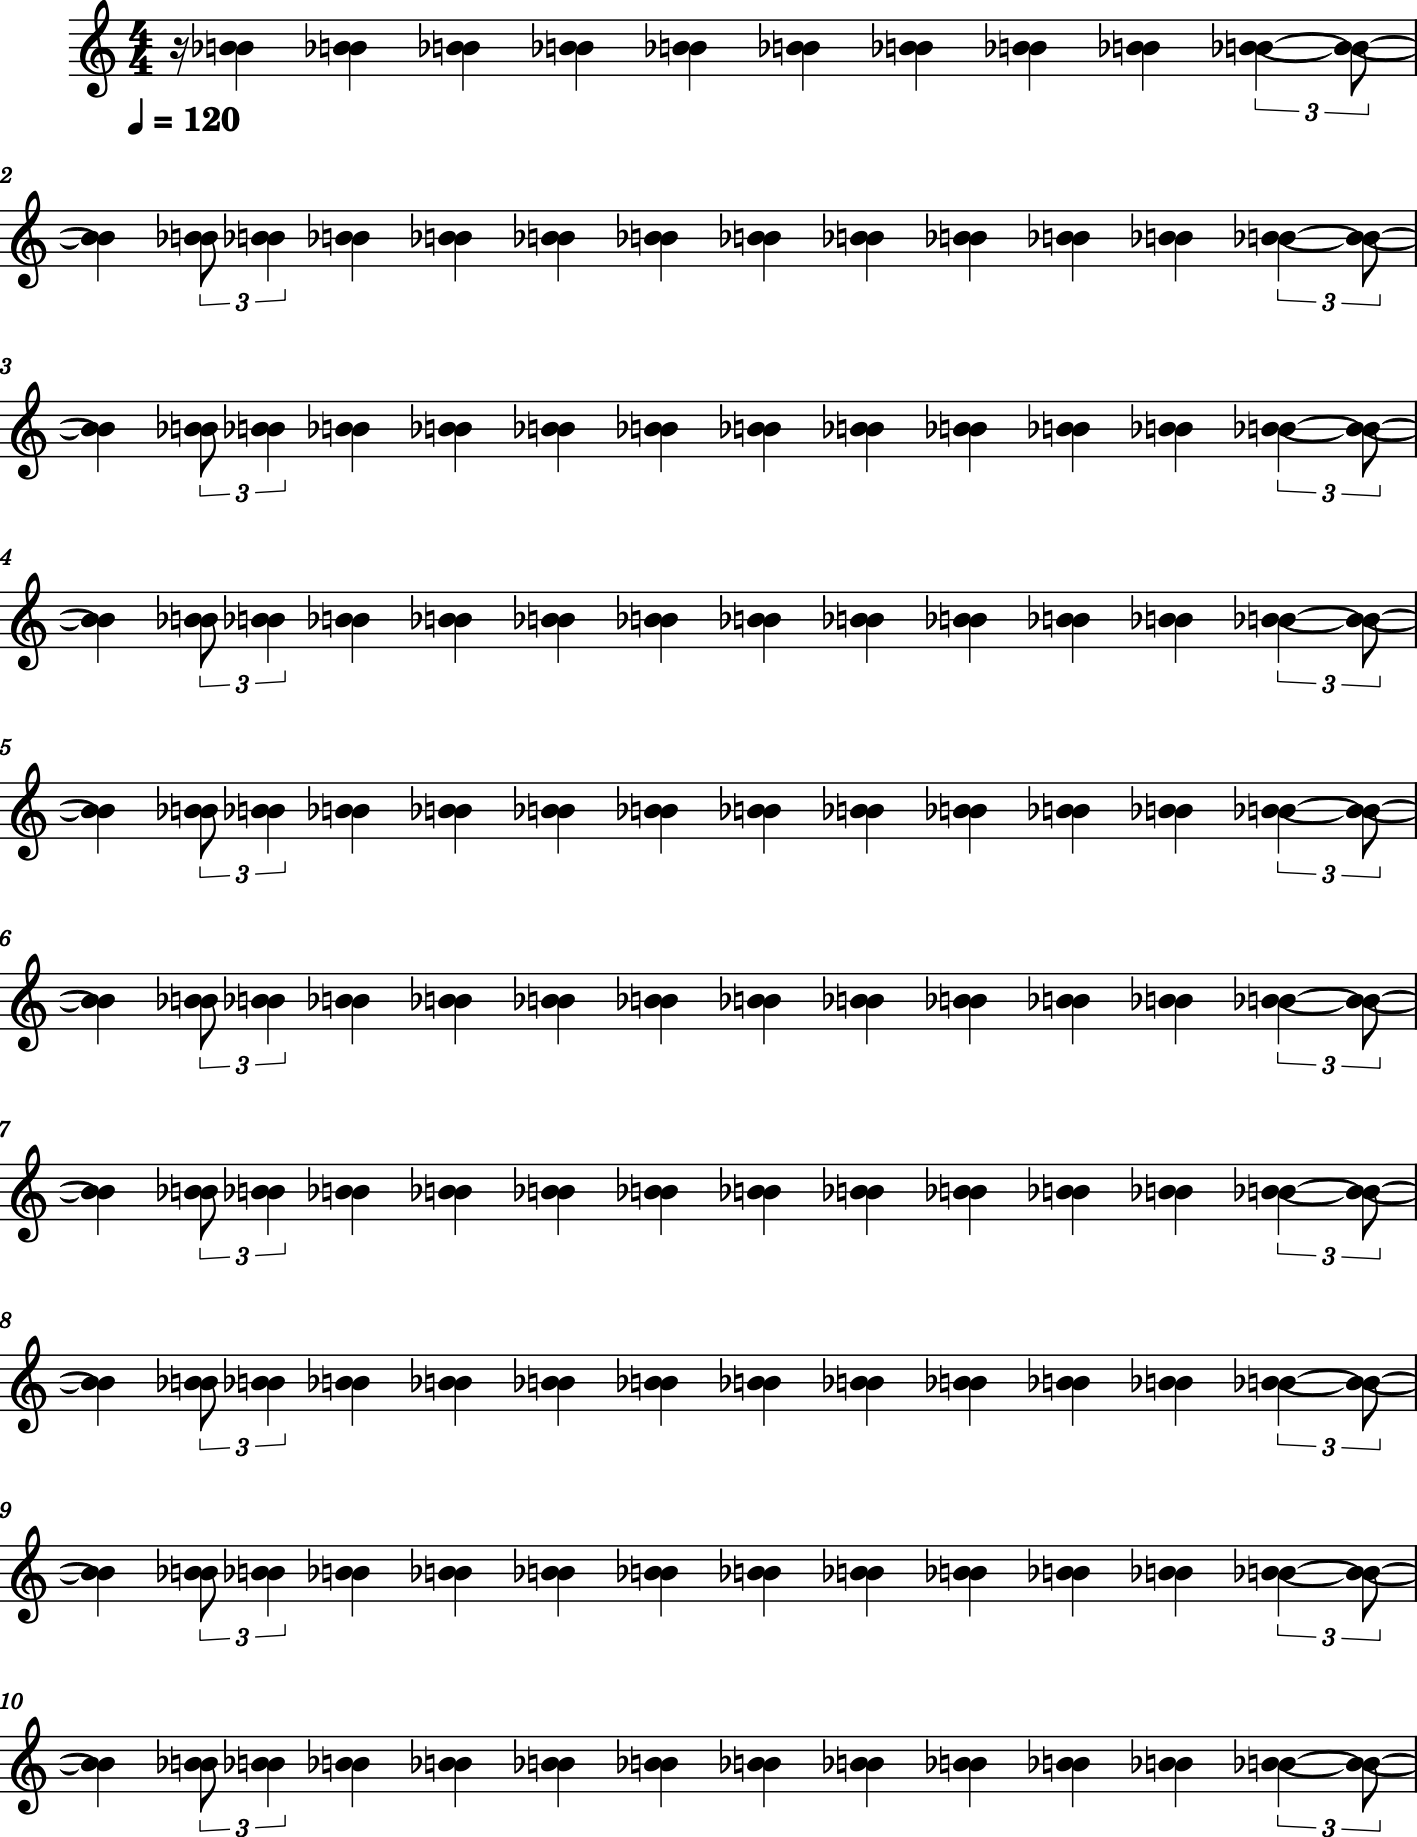

In [378]:
# Get the music score
Stream.show()